[13.42529766  0.08900381  0.07307235] [0.91310479 0.1398105  0.14465966]
MAP parameter vector: [13.42493827  9.49447974  0.43413876  0.64360036  0.9435316 ]
[13.80874081  0.04045059  0.04218651] [0.81315075 0.11764636 0.1156788 ]
MAP parameter vector: [13.80871675 16.02060574  0.26658207  0.35742343  0.81244309]
2 400000 5 400000
0.8919237801552451 0.21722622453874996 0.17121359769468747


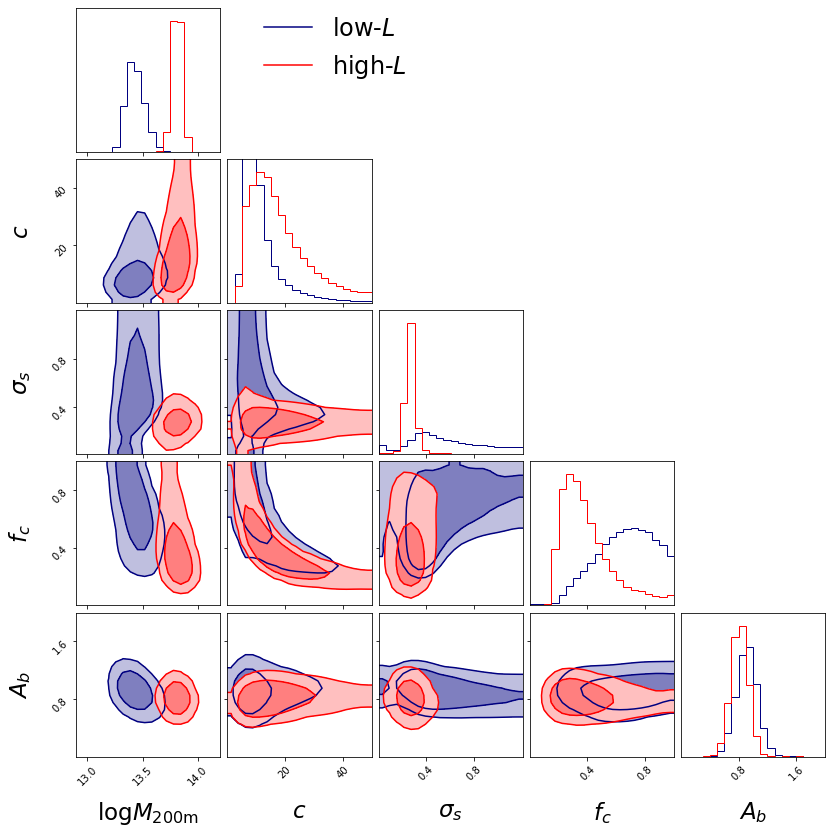

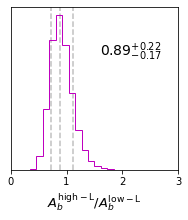

In [3]:
import matplotlib.pyplot as plt
import corner
import numpy as np 
import time
import matplotlib.lines as mlines
import random
from scipy.stats import gaussian_kde

# ################# read the result data ############################

nsteps = 10000
sp_labels = [r'log$M_{\rm 200m}$','$c$',r'$\sigma_s$',r'$f_c$','$A_b$']

CORNER_KWARGS = dict(
    smooth=0.99,
    label_kwargs=dict(fontsize=23),
    title_kwargs=dict(fontsize=23),
    #quantiles=[0.5-0.34, 0.5+0.34],
    levels=(0.,0.68,0.95),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=False,
    max_n_ticks=3,
    labels = sp_labels,
)


def overlaid_corner(samples_list, sample_labels, data_path):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    print(n, _, ndim, max_len)
    cmap = plt.cm.get_cmap('jet', n)
    colors = [cmap(i) for i in range(n)]
    colors = ['navy','r','g']

    """
    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )
    print(plot_range)
    """
    plot_range=[[12.9, 14.2], [0., 49.999591340949934], [0.010008443657552712, 1.1999969944968063], [3.3379863428689704e-05, 0.9999876490812971], [0., 2]]

    CORNER_KWARGS.update(range=plot_range)

    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)],
        fontsize=24, frameon=False,
        bbox_to_anchor=(-2.4, 4.92), loc="center"
    )
    plt.savefig(data_path,dpi=400,bbox_inches = 'tight')


def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)

nbin=2
num_par=len(sp_labels)
nburn=int(nsteps*0.1)
quantiles = np.array([16., 50., 84.])
results=np.zeros((nbin,num_par,3))
data_path1="data/ggl-chains-mag/"
result_fig=data_path1+"/corner_"+str(nsteps)+"-M-c-rs-fc-bh.png"
    
mapresults=np.zeros((nbin,num_par))
samples=[]
for isig in range(nbin):
    file_path1 = data_path1 + "chain_"+str(nsteps)+"_steps-intpl-M-c-rs-fc-bh-n"+str(isig+1)+".npz"
    data1 = np.load(file_path1)

    samples1 = np.array(data1['arr_0'])
    samples.append(samples1)
    parameter_results = np.percentile(samples1[nburn:,:], quantiles, axis=0)
    results[isig,:,0]=parameter_results[1,:]
    results[isig,:,1]=parameter_results[2,:]-parameter_results[1,:]
    results[isig,:,2]=parameter_results[1,:]-parameter_results[0,:]
    print(results[isig,0,:],results[isig,-1,:])

    samples2 = samples1[nburn:, :]  # burn-in 后的样本
    n_sub = 10000  # 或者 10000，别太大
    idx = np.random.choice(len(samples2), size=n_sub, replace=False)
    samples2 = samples2[idx, :]
    kde = gaussian_kde(samples2.T)

    # 计算每个样本点的 posterior density
    log_probs = kde.logpdf(samples2.T)
    # 找到最大概率点
    map_index = np.argmax(log_probs)
    map_point = samples2[map_index, :]
    mapresults[isig,:]=map_point
    print("MAP parameter vector:", map_point)

overlaid_corner([*samples],['low-$L$','high-$L$'], result_fig)
np.save(data_path1+"parameter_results-5par.npy",results)
np.savetxt(data_path1+"parameter_results_MAP-5par.dat",mapresults)

for isig in range(nbin):
    random.shuffle(samples[isig][nburn:,4])
    
ratio_all=np.zeros((3,1))
ratio_chains=samples[1][nburn:,4]/samples[0][nburn:,4]
ratio=np.percentile(ratio_chains, quantiles)
print(ratio[1],ratio[2]-ratio[1],ratio[1]-ratio[0])
ratio_all[0,0]=ratio[1]
ratio_all[1,0]=ratio[2]-ratio[1]
ratio_all[2,0]=ratio[1]-ratio[0]

text_str = r"${:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$".format(ratio[1], ratio_all[1,0], ratio_all[2,0])

plt.figure(figsize=(3,3))
alpha=0.5
plt.axvline(ratio[0], color='gray', linestyle='--',alpha=alpha)
plt.axvline(ratio[1],color='gray', linestyle='--',alpha=alpha)
plt.axvline(ratio[2],color='gray', linestyle='--',alpha=alpha)
plt.hist(ratio_chains,bins=np.linspace(0,4.5,40),histtype='step',color='m')
plt.text(1.6,71113.4,text_str,fontsize=14)
plt.xlabel(r"$A_b^{\rm high-L}/A_b^{\rm low-L}$",fontsize=13)
plt.yticks([]) 
plt.xlim(0,3)
plt.savefig(data_path1+"ratio_bh.png",dpi=400,bbox_inches = 'tight')

np.savetxt(data_path1+"ratio_bh.dat",ratio_all)


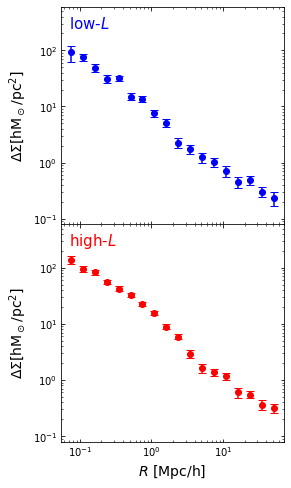

In [9]:
from sys import path, argv
import numpy as np
import emcee
import time
from multiprocessing import Pool
import pyccl as ccl
import matplotlib.pyplot as plt

start = time.time()

H0=67.36
h=H0/100.
omega_b=0.02237/h/h
omega_c=0.1200/h/h
omega_m=0.3153
omega_l=1.-omega_m
ns=0.9649
sigma8=0.8111
cosmo = ccl.Cosmology(Omega_c=omega_c, Omega_b=omega_b, h=h, sigma8=sigma8, n_s=ns,transfer_function='boltzmann_camb')

################### read the data #############################

nsig=2
h0=0.6736
nnseg=100

results_path="data/ggl-chains-mag/"
result=np.load(results_path+"parameter_results-5par.npy")
result_MAP=np.loadtxt(results_path+"parameter_results_MAP-5par.dat")

nrbin=18
rbin=np.logspace(np.log10(0.06),np.log10(60.),nrbin+1)
rr=(rbin[1:]**3-rbin[:-1]**3)/(rbin[1:]**2-rbin[:-1]**2)*2./3.

fig, ax = plt.subplots(2, 1, figsize=(4, 8), sharex=True, sharey=True)
for isig in range(nsig):
    xi=np.loadtxt(results_path+"cov/nornd-mean_gg-n"+str(isig+1)+".dat")
    ndata=len(xi)
    cov=np.loadtxt(results_path+"cov/nornd-cov_gg-n"+str(isig+1)+".dat")
    invcov=np.mat(np.linalg.inv(np.mat(cov)))
    par_res=result[isig,:,0]

    err=np.sqrt(np.diagonal(cov))

    ax1=isig

    if(ax1 == 0):
        ax[ax1].errorbar(rr,xi,yerr=err,fmt='o',capsize=4,c='b')
    else:
        ax[ax1].errorbar(rr,xi,yerr=err,fmt='o',capsize=4,c='r')

    ax[ax1].set_ylim(0.08,600)
    ax[ax1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
    
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].text(0.07,250,"low-$L$",fontsize=15,c='b')
ax[1].text(0.07,250,"high-$L$",fontsize=15,c='r')
ax[0].set_ylabel(r'$\Delta \Sigma [{\rm h M_\odot /pc}^2]$',fontsize=14)
ax[1].set_ylabel(r'$\Delta \Sigma [{\rm h M_\odot /pc}^2]$',fontsize=14)
ax[1].set_xlabel(r'$R$ [Mpc/h]',fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(results_path+'fit-paper-off.png',bbox_inches = 'tight',dpi=400)



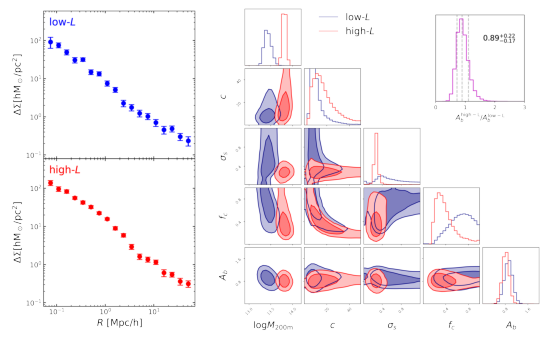

In [10]:
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

nsteps = 10000
image1 = results_path + 'fit-paper-off.png'
image2 = results_path + "/corner_" + str(nsteps) + "-M-c-rs-fc-bh.png"
image3 = results_path + "ratio_bh.png"  # 第三个图像文件
result_fig = results_path + "ggl_results.png"

# 读取图像
img1 = mpimg.imread(image1)
img2 = mpimg.imread(image2)
img3 = mpimg.imread(image3)  # 读取第三个图像

# 创建一个图形和两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 3]})  # 调整子图宽度比例

# 在第一个子图中显示图像1
ax1.imshow(img1)
ax1.set_yticks([])  # 隐藏y轴刻度和标签
ax1.set_xticks([])  # 隐藏x轴刻度和标签

# 在第二个子图中显示图像2
ax2.imshow(img2)
ax2.set_yticks([])  # 隐藏y轴刻度和标签
ax2.set_xticks([])  # 隐藏x轴刻度和标签

# 隐藏每个子图的边框
for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)

# 在第二个子图的右上角添加一个小的image3
axins = inset_axes(ax2, width="35%", height="35%", loc='upper right')  # 创建嵌入的小图
axins.imshow(img3)
axins.set_yticks([])  # 隐藏y轴刻度和标签
axins.set_xticks([])  # 隐藏x轴刻度和标签
axins.spines['top'].set_visible(False)  # 隐藏边框
axins.spines['right'].set_visible(False)
axins.spines['left'].set_visible(False)
axins.spines['bottom'].set_visible(False)

# 调整子图之间的距离
plt.subplots_adjust(wspace=-0.3)  # 调整子图之间的水平间距，值越小间距越小

# 保存最终图像到指定路径
plt.savefig(result_fig, dpi=500,bbox_inches = 'tight')  # 可以根据需要调整分辨率
